## code 1

In [1]:
import time
import os
import sys
import pybullet as p
from cairo_simulator.core.utils import ASSETS_PATH
from cairo_simulator.core.log import Logger
from cairo_simulator.core.link import *
from cairo_simulator.core.simulator import Simulator, SimObject
from manipulatorsMOD import SawyerMOD
from cairo_simulator.devices.manipulators import Sawyer
from cairo_simulator.devices.sensors import LaserRangeFinder
from utils import load_configuration, save_config_to_configuration_file, manual_control, create_cuboid_obstacle
from pybullet_utils import bullet_client as bc
from pybullet_utils import urdfEditor as ed
import pybullet_data
import time
import matplotlib.pyplot as plt
#%matplotlib inline
import random
from IPython.display import display, clear_output


def main():
    use_ros = False
    use_real_time = True
    logger = Logger()
    sim = Simulator(logger=logger, use_ros=use_ros, use_real_time=use_real_time) # Initialize the Simulator
    p.setGravity(0,0,-9.81)
    p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,0)
    #added numSolverIterations modification to hopefully increase "stiffness" of held block
    p.setPhysicsEngineParameter(enableFileCaching=0)
    #p.setPhysicsEngineParameter(numSolverIterations=100, numSubSteps=10) #numSolverIterations=100, numSubSteps=10) #
    p.setPhysicsEngineParameter(solverResidualThreshold=1e-30)

    ground_plane = SimObject("Ground", "plane.urdf", [0,0,0])
    table = SimObject('table', 'NEWtable.urdf',  (0.9, 0.1, .47),(1.5708*2,0,0),fixed_base=1)
    #print(p.getNumJoints(table.get_simulator_id()))
    
    
    p.configureDebugVisualizer(p.COV_ENABLE_GUI,0) #disable explorer and camera views
    #Point the camera at the robot at the desired angle and distance
    #p.resetDebugVisualizerCamera( cameraDistance=1.5, cameraYaw=-30, cameraPitch=-30, cameraTargetPosition=[0.0, 0.0, 0.25])  
    p.resetDebugVisualizerCamera( cameraDistance=1.3, cameraYaw=92, cameraPitch=-37, 
                                 cameraTargetPosition=[-0.001, 0.03, 0.03])  

    
    
    #block = SimObject('block1', '1block.urdf', (0.69, -0.2, .55))
    
    #remember, for future objects, enable concave features in the URDF files using pybullet quckstart guide, like:
    #https://github.com/bulletphysics/bullet3/blob/master/data/samurai.urdf
    #sim_obj0 = SimObject('hole1', '1block.urdf',  (0.69, -0.2, .530),(0,0,0),fixed_base=0) 
    sim_obj1 = SimObject('hole1', '1.5hole.urdf',  (0.69, 0.1, .530),(0,0,0),fixed_base=1)  #1.5708 for 90 deg rotation
    sim_obj2 = SimObject('hole2', '1.25hole.urdf', (0.69, 0.3, .530),(0,0,0),fixed_base=1)
    sim_obj3 = SimObject('hole3', '1.15hole.urdf', (0.69, 0.5, .530),(0,0,0),fixed_base=1)    
    sim_obj4 = SimObject('hole1', 'C_hole.urdf',  (0.69, -0.5, .530),(0,0,0),fixed_base=1) 
    
    
    #sim_obj6 = SimObject('1block', '1block.urdf', (0.69, 0.1, .8),(0,0,0),fixed_base=0)
    
    #robotfilelocation=ASSETS_PATH + 'sawyer_description/urdf/sawyer_static.urdf'
    #sawyer_robot = Sawyer("sawyer0", [0, 0, 0.8], fixed_base=1)
    
    sawyer_robot = SawyerMOD(robot_name="sawyer0"
                           ,position=[0, 0, 0.8], fixed_base=1)
    
    robotID=sawyer_robot.get_simulator_id() #numeric code for robot
    

    dofindex=[3, 8, 9, 10, 11, 13, 16]
    #to display all joint information
                             
    """
    print(sawyer_robot._arm_dof_indices) #[3, 8, 9, 10, 11, 13, 16]  #these correspond to the links
    print(sawyer_robot._arm_dof_names) #['right_j0', 'right_j1', 'right_j2', 'right_j3', 'right_j4', 'right_j5', 'right_j6']
    print(get_joint_info_by_name(7,"right_j6"))
    for x in dofindex:
        print(get_joint_info(6,x))
        print("  ")
    for i in range(p.getNumJoints(robotID)):
        j_info = p.getJointInfo(robotID, i)
        print(j_info)
    """
    #enable force/torque sensors at all joints
    for x in dofindex:
        p.enableJointForceTorqueSensor(robotID,x,enableSensor=1)  #args: bodyID#, jointIndex,enablesensor
    
    orientation= [0,1,0,0] #quaternion hand pointing down..ish?
    xoffset=0
    yoffset=0
    
    #initial positioning of arm
    
    #jointPositions = [0.4945952894928332,0.36252717211583246,-1.0367314784884951,0.7450178202705928,-1.6496244258385506,-0.9285887664326956,-0.016547220371921873]
    jointPositions = [0.5009041352157391,0.2951560129283386,-1.2254625531233645,0.8216155636392285,-1.5183997750913025,-1.096785632443942,-0.08396404586438821]
    initialjointPositions=jointPositions
    #print("joints",range(p.getNumJoints(robotID)))     
    #gripperdof=list(sawyer_robot._gripper_dof_indices)
    #fingerPositions=list(sawyer_robot.get_gripper_pct_finger_positions(1))  
    
    for y in range(len(dofindex)):
        p.resetJointState(robotID, dofindex[y], jointPositions[y])
    """    
    dofindex.extend(gripperdof) 
    jointPositions.extend(fingerPositions)

    for y in range(len(dofindex)):
        p.resetJointState(robotID, dofindex[y], jointPositions[y])   
    """    
 
    
    joint_config2 = [0.69+xoffset, 0.1+yoffset, 0.9]
    joint_config = sawyer_robot.solve_inverse_kinematics(joint_config2,orientation)
    
    sawyer_robot.move_to_joint_pos(joint_config) 
  
    p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)
    
    key_w = ord('k') #y up
    key_a = ord('u') #x down
    key_s = ord('h') #y down
    key_d = ord('j') #x up
    
    key_ccw = ord('y') #gripper counterclockwise rotation (yaw)
    key_cw = ord('i') #gripper clockwise rotation(yaw)
    
    key_pitchup = ord('d') #gripper counterclockwise rotation (yaw)
    key_pitchdown = ord('c') #gripper clockwise rotation(yaw)
    key_rollleft = ord('z') #gripper counterclockwise rotation (yaw)
    key_rollright = ord('x') #gripper clockwise rotation(yaw)
    
    key_o = ord('o') #z up
    key_l = ord('l') #z downkey_8 = ord('8')
    key_5 = ord('5')
    
    key_7 = ord('7')
    key_8 = ord('8') #print all 6dof force/torque info
    key_9 = ord('9') #print info
    key_p = ord('p') 
    
    loop_count = 0 # Loop until someone shuts us down
    xcurrent=0.69
    ycurrent=0.1
    zcurrent=0.9
    # the center of 1.5 hole is roughly 0.71  0.08 OR   ~0.78 in x and y
    a=0
    b=1
    c=0
    d=0
    orientation= [a,b,c,d] #quaternion hand pointing down..ish?
    
    x_forcelist=[]
    y_forcelist=[]
    z_forcelist=[]
    roll_torquelist=[]
    pitch_torquelist=[]
    yaw_torquelist=[]
    
    print("HK to jog_X         UJ to jog_Y           OL to jog_Z")
    print("ZX to roll          DC to Pitch           NM to Yaw(rotate end-effector)")
    print("8 for all joint force/torque, 9 for J16 and XYZ location")
    
    #fig = plt.figure()
    #ax = fig.add_subplot(1, 1, 1) 
    fig, (ax1, ax2) = plt.subplots(2,figsize=(8,8))
    
    
    
    
    
    #lrf_sensor = LaserRangeFinder(position_offset=[0.5,0.1,0.54],orientation_offset=[0,0,0,1],fixed_pose=False)
    #lrf_sensor.set_range(0.3,1.0) # Sensor takes readings from 0.3m to 1.0m away from its position.
    
    
    #0.0381
    #lrf_sensor = LaserRangeFinder(position_offset=[0.69-(0.0381/2), 0.1, .530-(0.02)],
    #                              orientation_offset=[0,0,0,1],fixed_pose=False)
    
    
    #lrf_sensor = LaserRangeFinder(position_offset=[0.69-(0.0381/2), 0.1, .530-(0.02)],
    #                              orientation_offset=[0, -0.7068252, 0, 0.7073883 ] ,fixed_pose=False) #vertical!
    lrf_sensor = LaserRangeFinder(position_offset=[0.69, 0.1, .530-(0.02)],
                                  orientation_offset=[0, -0.7068252, 0, 0.7073883 ] ,fixed_pose=False)
    
    lrf_sensor.set_range(0,0.0381) 
    
    
    lrf_sensor.set_debug_mode(True) 
    loop_count = 0
    
    while True:
            xoffset=0
            yoffset=0
            
            keys = p.getKeyboardEvents()
            if key_w in keys and keys[key_w] & p.KEY_WAS_TRIGGERED:
                ycurrent+=0.01
                xyz = [xcurrent, ycurrent, zcurrent]
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)
            if key_a in keys and keys[key_a] & p.KEY_WAS_TRIGGERED:
                xcurrent-=0.01
                xyz = [xcurrent, ycurrent, zcurrent]
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)
            if key_s in keys and keys[key_s] & p.KEY_WAS_TRIGGERED:
                ycurrent-=0.01
                xyz = [xcurrent, ycurrent, zcurrent]
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)
            if key_d in keys and keys[key_d] & p.KEY_WAS_TRIGGERED:
                xcurrent+=0.01
                xyz = [xcurrent, ycurrent, zcurrent]
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)
                
                
            if key_o in keys and keys[key_o] & p.KEY_WAS_TRIGGERED:
                zcurrent+=0.01
                xyz = [xcurrent, ycurrent, zcurrent]
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)
            if key_l in keys and keys[key_l] & p.KEY_WAS_TRIGGERED:
                zcurrent-=0.01
                xyz = [xcurrent, ycurrent, zcurrent]
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)  
                
            if key_cw in keys and keys[key_cw] & p.KEY_WAS_TRIGGERED:
                xyz = [xcurrent, ycurrent, zcurrent]
                a+=0.03 #a= yaw- use this! c= roll d= pitch
                orientation= [a,b,c,d] #[0,1,0,0] default #quaternion hand pointing down..ish?
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)

            if key_ccw in keys and keys[key_ccw] & p.KEY_WAS_TRIGGERED:
                xyz = [xcurrent, ycurrent, zcurrent]
                a-=0.03 #a= yaw- use this! c= roll d= pitch
                orientation= [a,b,c,d] #[0,1,0,0] default #quaternion hand pointing down..ish?
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)
                
            if key_pitchup in keys and keys[key_pitchup] & p.KEY_WAS_TRIGGERED:
                xyz = [xcurrent, ycurrent, zcurrent]
                d-=0.03 #a= yaw- use this! c= roll d= pitch
                orientation= [a,b,c,d] #[0,1,0,0] default #quaternion hand pointing down..ish?
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)

            if key_pitchdown in keys and keys[key_pitchdown] & p.KEY_WAS_TRIGGERED:
                xyz = [xcurrent, ycurrent, zcurrent]
                d+=0.03 #a= yaw- use this! c= roll d= pitch
                orientation= [a,b,c,d] #[0,1,0,0] default #quaternion hand pointing down..ish?
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)
            if key_rollleft in keys and keys[key_rollleft] & p.KEY_WAS_TRIGGERED:
                xyz = [xcurrent, ycurrent, zcurrent]
                c-=0.03 #a= yaw- use this! c= roll d= pitch
                orientation= [a,b,c,d] #[0,1,0,0] default #quaternion hand pointing down..ish?
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)

            if key_rollright in keys and keys[key_rollright] & p.KEY_WAS_TRIGGERED:
                xyz = [xcurrent, ycurrent, zcurrent]
                c+=0.03 #a= yaw- use this! c= roll d= pitch
                orientation= [a,b,c,d] #[0,1,0,0] default #quaternion hand pointing down..ish?
                joint_config = sawyer_robot.solve_inverse_kinematics(xyz,orientation)
                sawyer_robot.move_to_joint_pos(joint_config)    

            if key_5 in keys and keys[key_5] & p.KEY_WAS_TRIGGERED:
                #Get camera position 
                #last sets of values are: yaw, pitch, dist,target(list of 3 floats)
                #plug values into resetDebugVisualizerCamera command at the top to set the initial camera view. 
                print(p.getDebugVisualizerCamera())
                
            if key_7 in keys and keys[key_7] & p.KEY_WAS_TRIGGERED:
                dofindex=[3, 8, 9, 10, 11, 13, 16]
                print("All Joint positions")
                for x in dofindex:
                    jointinfo=p.getJointState(robotID,int(x)) 
                    #rounded6dof = [round(num, 3) for num in jointinfo[2]]
                    print("J", x , " ", jointinfo[0]) 
        
            if key_8 in keys and keys[key_8] & p.KEY_WAS_TRIGGERED:
                dofindex=[3, 8, 9, 10, 11, 13, 16]
                print("All Joint Reaction Forces")
                for x in dofindex:
                    jointinfo=p.getJointState(robotID,int(x))  
                    #jointPosition,jointVelocity,(6dof)jointReactionForces, appliedJointMotorTorque
                    rounded6dof = [round(num, 3) for num in jointinfo[2]]
                    print("J", x , " ", rounded6dof) 
                
            if key_9 in keys and keys[key_9] & p.KEY_WAS_TRIGGERED:
                print(" ")
                print("location", xcurrent,"  ",ycurrent,"  ",zcurrent)
                #print("enter joint number [3, 8, 9, 10, 11, 13, 16]")
                #a = input()
                #jointinfo=p.getJointState(7,16) 
                #jointinfo=p.getJointState(7,int(a))
                jointinfo=p.getJointState(robotID,16) 
                rounded6dof = [round(num, 3) for num in jointinfo[2]]
                print("J 16",rounded6dof)
                #print(jointinfo)
                
            if key_p in keys and keys[key_p] & p.KEY_WAS_TRIGGERED:
                print(" ")
                print("test")
                dofindex=[3, 8, 9, 10, 11, 13, 16]
                state=sawyer_robot.get_current_joint_states() 
                state2=[]
                for i in dofindex:
                    state2.append(p.getJointState(robotID,i)[0])
                print("state")
                print(state)
                print("state2")
                print(state2)                             
                sawyer_robot.move_to_joint_pos(state2) 
                
            #To plot Forces and Torques
            #dofindex=[3, 8, 9, 10, 11, 13, 16]
            for x in dofindex:
                jointinfo=p.getJointState(robotID,int(x))  
                rounded6dof = [round(num, 3) for num in jointinfo[2]]
               
            x_forcelist.append(rounded6dof[0])
            y_forcelist.append(rounded6dof[1])
            z_forcelist.append(rounded6dof[2])
            roll_torquelist.append(rounded6dof[3])
            pitch_torquelist.append(rounded6dof[4])
            yaw_torquelist.append(rounded6dof[5])
            
            
            
            """
            ax1.legend([x_forcelist, y_forcelist, z_forcelist],['x', 'y', 'z'])
    
            ax2.legend([roll_torquelist,pitch_torquelist,yaw_torquelist], 
                       ['roll-torque','pitch-torque','yaw-torque'])
            """
            
            ax1.cla() #clear axes 
            ax2.cla() #clear axes 
            ax1.plot(x_forcelist)
            ax1.plot(y_forcelist)
            ax1.plot(z_forcelist)
            
            ax2.plot(roll_torquelist)
            ax2.plot(pitch_torquelist)
            ax2.plot(yaw_torquelist)
            plt.setp(ax1, xlim=(0, 20), ylim=(-2000,2000))
            plt.setp(ax2, xlim=(0, 20), ylim=(-2000,2000))
            
            
            
            
            display(fig)

            if len(x_forcelist)>20:
                x_forcelist.pop(0)
                y_forcelist.pop(0)
                z_forcelist.pop(0)
                roll_torquelist.pop(0)
                pitch_torquelist.pop(0)
                yaw_torquelist.pop(0)
                
            
            dist = lrf_sensor.get_reading()
            sim.logger.info("Detector Pos: %s \t\t\t Det: %f" % (lrf_sensor._position_offset, dist))
            
            """"""
            clear_output(wait = True)
            
            time.sleep(1./60.)
            sim.step()
            #loop_count = 0
            #if loop_count % 100 == 0:    
            #clear_output(wait = True)
            #loop_count += 1 
                
    #manual_control(sawyer_robot)   
    
    """
    try:
        while True:
            sim.step()
           
            
            
    except KeyboardInterrupt:
        p.disconnect()
        sys.exit(0)
        
    """ 

In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/scott/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

KeyboardInterrupt: 

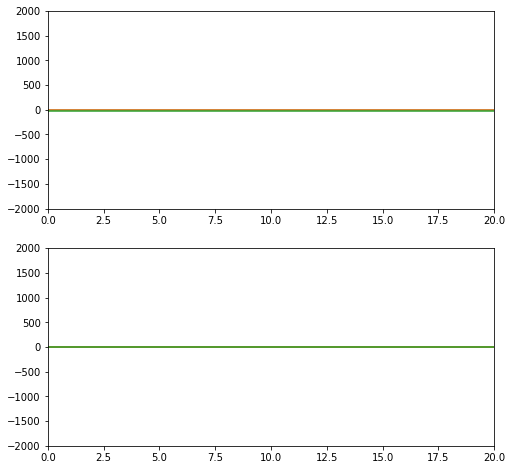

In [2]:
main()


## code 2


In [ ]:
'''
Simple demo showing how to use a LaserRangeFinder sensor within CAIRO Sim.
Use the 1-4 keys to move the sensor around, check the terminal for readings from the sensor.
'''

import time
import os
import sys

import pybullet as p
import numpy as np
from cairo_simulator.core.simulator import Simulator, SimObject
from cairo_simulator.core.utils import ASSETS_PATH
from cairo_simulator.core.log import Logger
from cairo_simulator.devices.sensors import LaserRangeFinder
from IPython.display import clear_output

def main():

    use_ros = False
    use_real_time = True

    logger = Logger()
    sim = Simulator(logger=logger, use_ros=use_ros, use_real_time=use_real_time) # Initialize the Simulator
    p.setGravity(0, 0, 0)
    p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,0)
    p.setPhysicsEngineParameter(enableFileCaching=0)

    # Add a few 0.05m x 0.05m x 0.05m cubes
    for idx in range(1,10):
        cube = SimObject(object_name="Cube%d"%idx, model_file_or_sim_id="cube_small.urdf", position=[0,0,idx/4.], orientation=[0,0,0,1])
        cube.move_to_pose([0,0,idx/4.],[0,0,0,1])
    # Add the sensor
    lrf_sensor = LaserRangeFinder(position_offset=[-0.5,0,0.3], fixed_pose=False)
    lrf_sensor.set_range(0.3,1.0) # Sensor takes readings from 0.3m to 1.0m away from its position.
    lrf_sensor.set_debug_mode(True)

    p.configureDebugVisualizer(p.COV_ENABLE_RENDERING,1)
    z_inc_key = ord('1') # Press 1 to increase Z position of sensor
    z_dec_key = ord('2') # Press 2 to decrease Z position of sensor
    y_inc_key = ord('3') # Press 3 to increase Y position of sensor
    y_dec_key = ord('4') # Press 4 to decrease Y position of sensor

    loop_count = 0
    # Loop until someone shuts us down
    try:
        while True:

            # Control the sensor position
            keys = p.getKeyboardEvents()
            if z_inc_key in keys and keys[z_inc_key] & p.KEY_WAS_TRIGGERED:
                lrf_sensor._position_offset += np.array([0, 0, 0.05,])
            if z_dec_key in keys and keys[z_dec_key] & p.KEY_WAS_TRIGGERED:
                lrf_sensor._position_offset -= np.array([0, 0, 0.05,]) 
            if y_inc_key in keys and keys[y_inc_key] & p.KEY_WAS_TRIGGERED:
                lrf_sensor._position_offset += np.array([0, 0.05, 0,])
            if y_dec_key in keys and keys[y_dec_key] & p.KEY_WAS_TRIGGERED:
                lrf_sensor._position_offset -= np.array([0, 0.05, 0,]) 

            # Get and display a reading from the sensor
            if loop_count % 10 == 0:
                dist = lrf_sensor.get_reading()
                sim.logger.info("Detector Pos: %s \t\t\t Det: %f" % (lrf_sensor._position_offset, dist))
                loop_count = 0
            if loop_count % 100 == 0:    
                clear_output(wait = True)
                
            loop_count += 1            
            sim.step()
            time.sleep(1./60.)
    except KeyboardInterrupt:
        p.disconnect()
        sys.exit(0)
   



if __name__ == "__main__":
    main()

Detector Pos: [-5.00000000e-01  1.38777878e-17  2.50000000e-01] 			 Det: 0.475000
